# MNE PIPELINE FOR SOURCE ESTIMATION

In [31]:
import os.path as op

import matplotlib.pyplot as plt
from mayavi import mlab
import numpy as np

import mne
from mne.datasets import sample

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

%matplotlib inline

## Create forward solution

To estimate the forward solution, we need:

- a head model
- a source model

To estimate both, we need the mri data of one subject. Fortunately, MNE computed the forward model from one example for us. 

Let's load the forward model:

In [32]:
# Load the fwd solution of one subject
data_path = sample.data_path()
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fwd_fname, verbose=False)
print(fwd)

<Forward | MEG channels: 306 | EEG channels: 60 | Source space: Surface with 7498 vertices | Source orientation: Free>


## Simulate source-space raw data

To simulate data we need:
- a source space template (that we can extract from the forward model)
- an info structure from the sample subject
- information about the events in the experiment

In [33]:
src = fwd['src']

We also need to define the info structure from the sample subject:

In [34]:
subjects_dir = op.join(data_path, 'subjects')
subject = 'sample'
meg_path = op.join(data_path, 'MEG', subject)
fname_info = op.join(meg_path, 'sample_audvis_raw.fif')
info = mne.io.read_info(fname_info, verbose=False)

And define our events information:

In [35]:
tstep = 1 / info['sfreq']
fname_event = op.join(meg_path, 'sample_audvis_raw-eve.fif')
events = mne.read_events(fname_event)

We simulate our deep-sources of interest:

In [36]:
# Define which events IDs in our events matrix will correspond to the brain activity of interest
event_id = {'PARAHIP': 1}

# Define the parcellation model
annot = 'aparc.a2009s' # https://www.sciencedirect.com/science/article/pii/S1053811910008542?via%3Dihub 

# Define the labels of relevant regions
activations = {'PARAHIP': ['G_oc-temp_med-Parahip-lh', 1]} # label, activation (nAm)]

# Create a list of region names
region_names = list(activations.keys())

# Create a sine wave as the time course of the activity for each region to activate
source_time_series = np.sin(np.linspace(0, 1 * np.pi, 100)) * 10e-9

# Create the SourceSimulator object
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)

# Assign peak activation at location of interest during relevant event_idx 
for region in region_names:
    region_id = event_id[region]
    events_tmp = events[np.where(events[:, 2] == region_id)[0], :]
    label_name = activations[region][0]
    label_tmp = mne.read_labels_from_annot(subject, annot,
                                           subjects_dir=subjects_dir,
                                           regexp=label_name,
                                           verbose=False)
    label_tmp = label_tmp[0]
    amplitude_tmp = activations[region][1]
    source_simulator.add_data(label_tmp,
                              amplitude_tmp * source_time_series,
                              events_tmp)

Let's now plot our source simulated data (a.k.a. the ground truth data):

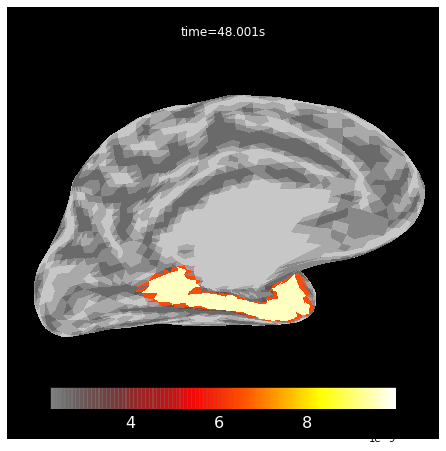

In [37]:
# Get the source simulation
stc_data = source_simulator.get_stc()

# Plot source activation at peak time
brain = stc_data.plot(subjects_dir=subjects_dir, initial_time=48, verbose=False,
                      hemi='lh', views='med', backend='matplotlib')

brain.show()

## Simulate sensor space data

From the ground truth data in source space, we simulate noisy data in sensor space

In [38]:
# Load raw data
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, verbose=False)
raw.set_eeg_reference(projection=True)

<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 166800 (277.7 sec), ~3.7 MB, data not loaded>

In [39]:
# Simulate raw data
raw_sim = mne.simulation.simulate_raw(info, source_simulator, forward=fwd,
                                      cov=None, verbose=False)

raw_sim.set_eeg_reference(projection=True).crop(0, 60)  # for speed

# Create noise covariance matrix
noise_cov = mne.make_ad_hoc_cov(raw_sim.info)

# Add artifacts
mne.simulation.add_noise(raw_sim, cov=noise_cov, random_state=0, verbose=False)
mne.simulation.add_eog(raw_sim, random_state=0, verbose=False)
mne.simulation.add_ecg(raw_sim, random_state=0, verbose=False)

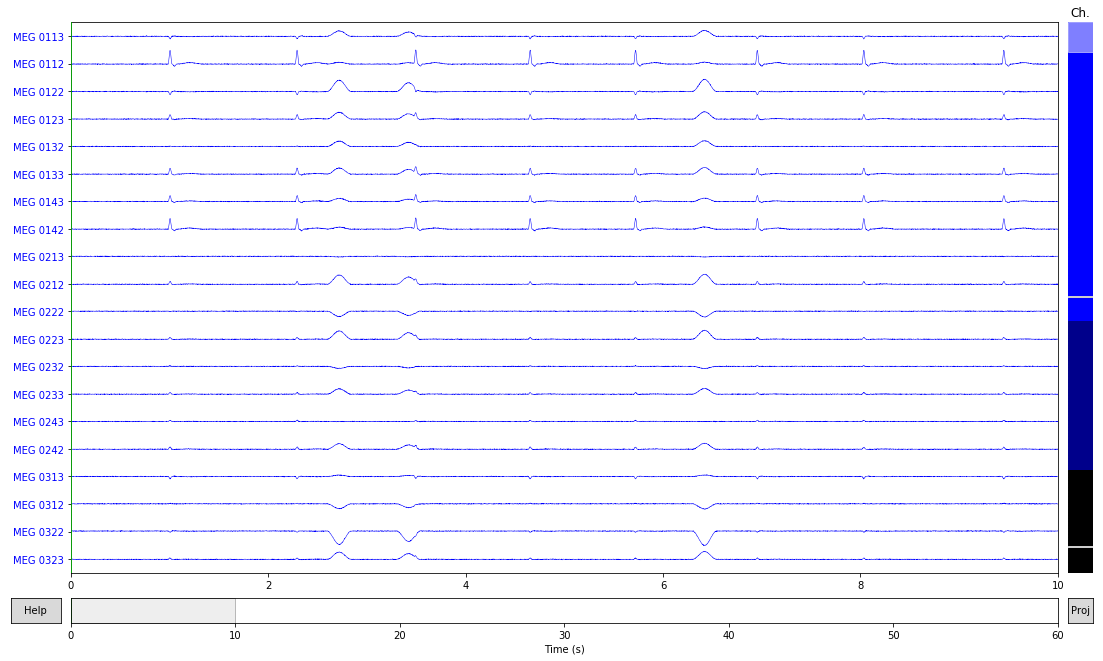

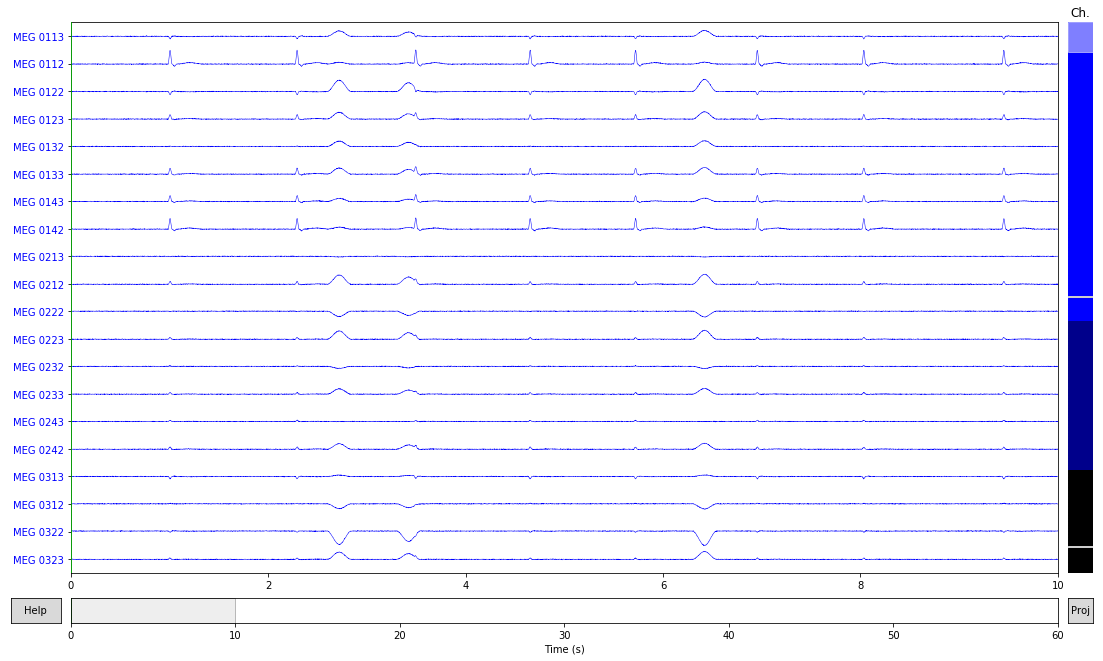

In [40]:
# Plot original and simulated raw data.
raw_sim.plot(title='Simulated raw data')

## Compute inverse models

### Compute inverse with MNE (Minimum Norm Estimate)

In [41]:
# Create inverse operator
inv_mne = mne.minimum_norm.make_inverse_operator(raw_sim.info, fwd, noise_cov, verbose=False)

# Define parameters
snr = 1.0  # use smaller SNR for raw data
lambda2 = 1.0 / snr ** 2
method = 'MNE'

# Apply inverse operator
stc_mne = mne.minimum_norm.apply_inverse_raw(raw_sim, inv_mne, lambda2, method,
                                             pick_ori=None, verbose=False)

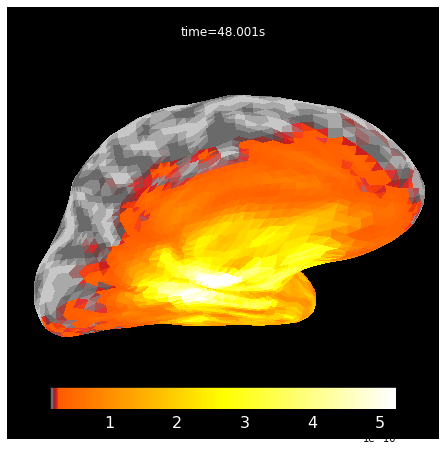

In [42]:
# Plot reconstructed signal
stc_mne_plot = stc_mne.plot(subjects_dir=subjects_dir, initial_time=48,
                             hemi='lh', views='med', backend='matplotlib', verbose=False)

### Compute inverse with beamformer

In [43]:
# Compute data covariance matrix
data_cov = mne.compute_raw_covariance(raw_sim, verbose=False)

# Create inverse operator
filters = mne.beamformer.make_lcmv(raw_sim.info, fwd, data_cov, 0.03, noise_cov,
                                   pick_ori='max-power', weight_norm='nai', verbose=False)

# Apply inverse operator
stc_bf = mne.beamformer.apply_lcmv_raw(raw_sim, filters, max_ori_out='signed')

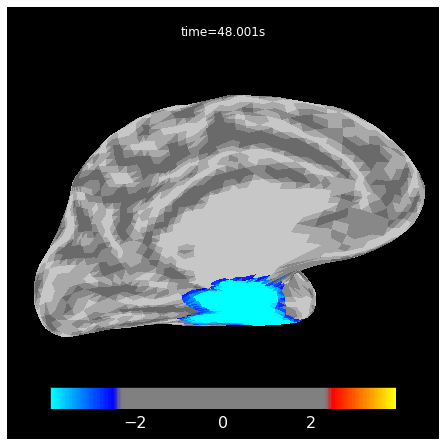

In [30]:
# Plot estimated source
stc_bf_plot = stc_bf.plot(subjects_dir=subjects_dir, initial_time=48, 
                          hemi='lh', views='med', backend='matplotlib', verbose=False)